<a href="https://colab.research.google.com/github/aidaazzahraa/Sentiment-Analysis-for-Depression-Detection-with-NLP/blob/main/Depression_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Penerapan Teknologi NLP dalam Mendeteksi Depresi Berdasarkan Analisis Sentimen Teks**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Data Acquisition**

In [ ]:
# Menginstal library Kaggle untuk mengunduh dataset dari Kaggle
!pip install -q kaggle

# Membuat direktori untuk menyimpan file autentikasi API Kaggle
!mkdir ~/.kaggle

# Menyalin file kaggle.json ke direktori Kaggle
!cp kaggle.json ~/.kaggle

# Memastikan library Kaggle selalu versi terbaru
!pip install --upgrade kaggle

# Mengunduh dataset dari Kaggle menggunakan perintah Kaggle CLI
!kaggle datasets download -d lekhnath/short-text-dataset-for-depression-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/lekhnath/short-text-dataset-for-depression-classification
License(s): MIT
short-text-dataset-for-depression-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Mengekstrak file ZIP dari dataset yang telah diunduh
!unzip /content/short-text-dataset-for-depression-classification.zip

Archive:  /content/short-text-dataset-for-depression-classification.zip
replace depression-classification-text-dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
df = pd.read_csv("depression-classification-text-dataset.csv")
df.head()

,text,label
0,"I'm feeling really down today, like everything...",1.0
1,"Just had a great workout, feeling fantastic an...",0.0
2,I can't seem to shake this feeling of emptines...,1.0
3,"Spent the day with friends, laughing and enjoy...",0.0
4,"I don't see the point in anything anymore, it ...",1.0


In [ ]:
label_counts = df['label'].value_counts()
print("Jumlah data per kategori:")
print(label_counts)

Jumlah data per kategori:
label
0.0    820
1.0    767
Name: count, dtype: int64


# **Data Cleaning**

In [ ]:
# Mengecek jumlah nilai kosong di setiap kolom
missing_values = df.isnull().sum()
print("Jumlah nilai kosong di setiap kolom:")
print(missing_values)

Jumlah nilai kosong di setiap kolom:
text     0
label    1
dtype: int64


In [ ]:
# Menghapus baris yang mengandung nilai kosong
df_cleaned = df.dropna()
print("\nData setelah menghapus nilai kosong:")
print(df_cleaned.head())


Data setelah menghapus nilai kosong:
                                                text  label
0  I'm feeling really down today, like everything...    1.0
1  Just had a great workout, feeling fantastic an...    0.0
2  I can't seem to shake this feeling of emptines...    1.0
3  Spent the day with friends, laughing and enjoy...    0.0
4  I don't see the point in anything anymore, it ...    1.0


In [ ]:
# Menampilkan jumlah data bersih per kategori di kolom `label`
cleaned_label_counts = df_cleaned['label'].value_counts()
print("\nJumlah data per kategori setelah pembersihan:")
print(cleaned_label_counts)


Jumlah data per kategori setelah pembersihan:
label
0.0    820
1.0    767
Name: count, dtype: int64


In [ ]:
# Menampilkan data setelah cleaning
print("\nData setelah proses cleaning:")
print(df_cleaned)


Data setelah proses cleaning:
                                                   text  label
0     I'm feeling really down today, like everything...    1.0
1     Just had a great workout, feeling fantastic an...    0.0
2     I can't seem to shake this feeling of emptines...    1.0
3     Spent the day with friends, laughing and enjoy...    0.0
4     I don't see the point in anything anymore, it ...    1.0
...                                                 ...    ...
1583           Lost in a maze of endless possibilities.    1.0
1584       Seeking refuge in the sanctuary of solitude.    0.0
1585             Lost in the wilderness of my own mind.    1.0
1586         Finding strength in the face of adversity.    0.0
1587          Adrift in a sea of uncertainty and doubt.    1.0

[1587 rows x 2 columns]


In [ ]:
# Menyimpan data bersih ke file CSV
df_cleaned.to_csv('data_cleaned.csv', index=False)

In [ ]:
data = pd.read_csv("data_cleaned.csv")
data.head()

,text,label
0,"I'm feeling really down today, like everything...",1.0
1,"Just had a great workout, feeling fantastic an...",0.0
2,I can't seem to shake this feeling of emptines...,1.0
3,"Spent the day with friends, laughing and enjoy...",0.0
4,"I don't see the point in anything anymore, it ...",1.0


In [ ]:
# Membuat distribusi jumlah status
status_counts = data['label'].value_counts().reset_index()
status_counts.columns = ['label', 'count']

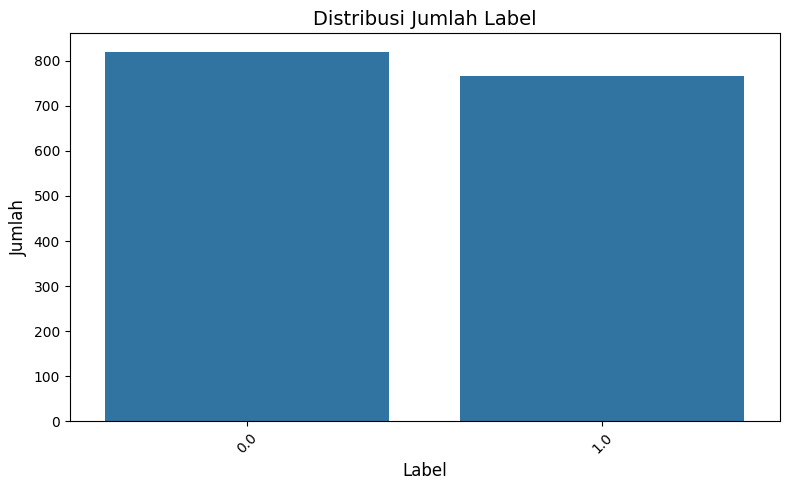

In [ ]:
import seaborn as sns

# Membuat grafik distribusi
plt.figure(figsize=(8, 5))
sns.barplot(x='label', y='count', data=status_counts)
plt.title('Distribusi Jumlah Label', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Tampilkan grafik
plt.show()

# **Data Prepocessing**

## **Case Folding**

In [ ]:
# Case Folding (menjadikan semua teks huruf kecil dan menghapus karakter tidak penting)
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'[^a-z\s]', '', text)              # Hapus karakter selain huruf
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'\b(\w)\1{2,}\b', '', text)        # Hapus kata dengan pengulangan karakter >= 3
  text = re.sub(r'\b\w{16,}\b', '', text)           # Hapus kata dengan panjang lebih dari 15 karakter
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = re.sub(r'\\s+', '  ', text)                # Menghapus spasi berlebih
  text = text.strip()                               # Menghapus spasi di awal/akhir teks
  return text

In [ ]:
raw_sample = data['text'].iloc[1]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  Just had a great workout, feeling fantastic and full of energy!
Case folding	:  just had a great workout feeling fantastic and full of energy


## **Word Normalization**

In [ ]:
key_norm = pd.read_csv('Abbreviations and Slang.csv')

In [ ]:
# Kamus tambahan untuk singkatan yang tidak ada di dalam file CSV
additional_dict = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "im": "i am",
    "dont": "do not",
    "wanna": "want to",
    "gonna": "going to",
    "btw": "by the way",
    "idk": "i do not know",
    "lol": "laugh out loud",
    "omg": "oh my god",
    "cant": "cannot",
    "ive": "i have",
    "rn": "right now",
    "thx": "thanks",
    "pls": "please",
    "til": "today i learned",
    "etc": "and so on",
    "id": "i would",
    "youre": "you are",
    "itll": "it will",
    "whats": "what is",
    "theyre": "they are",
    "shes": "she is",
    "hes": "he is",
    "lets": "let us",
    "thats": "that is",
    "heres": "here is",
    "wont": "will not",
    "didnt": "did not",
    "couldnt": "could not",
    "wouldnt": "would not",
    "shouldnt": "should not",
    "isnt": "is not",
    "arent": "are not",
    "wasnt": "was not",
    "werent": "were not",
    "youll": "you will",
    "itll": "it will",
    "hell": "he will",
    "shell": "she will",
    "well": "we will",
    "theyll": "they will",
    "ill": "i will",
    "thatll": "that will",
    "therell": "there will",
    "whatll": "what will",
    "wholl": "who will"
}

In [ ]:
normalization_dict = {**dict(zip(key_norm['Abbreviations'], key_norm['Text'])), **additional_dict}

In [ ]:
def text_normalize(text):
  text = ' '.join([normalization_dict.get(word, word) for word in text.split()])
  text = str.lower(text)
  return text

In [ ]:
raw_sample = data['text'].iloc[1]
case_folding = casefolding(raw_sample)
normalized_text = text_normalize(case_folding)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)
print('Normalized text\t: ', normalized_text)

Raw data	:  Just had a great workout, feeling fantastic and full of energy!
Case folding	:  just had a great workout feeling fantastic and full of energy
Normalized text	:  just had a great workout feeling fantastic and full of energy


## **Filtering (Stopword Removal)**

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_eng = stopwords.words('english')

In [ ]:
len(stopwords_eng)

179

In [ ]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_eng

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
# Melihat 20 kata paling sering muncul
from collections import Counter

# Gabungkan semua kata dalam satu list
all_words = ' '.join(data['text'].astype(object).apply(casefolding, normalized_text)).split()

# Hitung frekuensi kata
word_freq = Counter(all_words)

# Tampilkan 20 kata yang paling sering muncul
print(word_freq.most_common(20))

[('the', 700), ('i', 699), ('feeling', 695), ('a', 656), ('of', 452), ('to', 370), ('im', 363), ('in', 333), ('like', 316), ('day', 294), ('with', 243), ('feel', 239), ('my', 212), ('spent', 196), ('from', 158), ('own', 156), ('this', 155), ('dont', 139), ('keep', 137), ('for', 120)]


<ipython-input-123-81c9950a2f06>:5: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  all_words = ' '.join(data['text'].astype(object).apply(casefolding, normalized_text)).split()


In [ ]:
# Contoh penambahan stopword sesuai hasil
# more_stopword = ['']
# stopwords_eng = stopwords_eng + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_eng:
          clean_words.append(word)
  return " ".join(clean_words)

# Terapkan pada kolom teks
data['text'] = data['text'].apply(remove_stop_words)

In [ ]:
raw_sample = data['text'].iloc[1]
case_folding = casefolding(raw_sample)
normalized_text = text_normalize(case_folding)
stopword_removal = remove_stop_words(normalized_text)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Normalized text\t\t: ', normalized_text)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  Just great workout, feeling fantastic full energy!
Case folding		:  just great workout feeling fantastic full energy
Normalized text		:  just great workout feeling fantastic full energy
Stopword removal	:  great workout feeling fantastic full energy


## **Stemming**

In [ ]:
from nltk.stem import PorterStemmer

# Inisialisasi PorterStemmer
stemmer = PorterStemmer()

# Fungsi untuk stemming
def stemming(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)

In [ ]:
raw_sample = data['text'].iloc[1]
case_folding = casefolding(raw_sample)
normalized_text = text_normalize(case_folding)
stopword_removal = remove_stop_words(normalized_text)
text_stemming = stemming(stopword_removal)


print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Normalized text\t\t: ', normalized_text)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  Just great workout, feeling fantastic full energy!
Case folding		:  just great workout feeling fantastic full energy
Normalized text		:  just great workout feeling fantastic full energy
Stopword removal	:  great workout feeling fantastic full energy
Stemming		:  great workout feel fantast full energi


In [ ]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [ ]:
%%time
data['clean_teks'] = data['text'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: user 466 ms, sys: 569 µs, total: 467 ms
Wall time: 643 ms


In [ ]:
data

,text,label,clean_teks
0,"I'm feeling really today, like everything fall...",1.0,feel realli today like everyth fall apart
1,"Just great workout, feeling fantastic full ene...",0.0,great workout feel fantast full energi
2,I can't seem shake feeling emptiness that's li...,1.0,cannot seem shake feel empti linger day
3,"Spent day friends, laughing enjoying other's c...",0.0,spent day friend laugh enjoy other compani
4,"I see point anything anymore, feels meaningless.",1.0,see point anyth anymor feel meaningless
...,...,...,...
1582,Lost maze endless possibilities.,1.0,lost maze endless possibl
1583,Seeking refuge sanctuary solitude.,0.0,seek refug sanctuari solitud
1584,Lost wilderness mind.,1.0,lost wilder mind
1585,Finding strength face adversity.,0.0,find strength face advers


# **Feature Engineering**

In [ ]:
# Pisahkan kolom feature dan target
X = data['clean_teks']
y = data['label']

In [ ]:
X

,clean_teks
0,feel realli today like everyth fall apart
1,great workout feel fantast full energi
2,cannot seem shake feel empti linger day
3,spent day friend laugh enjoy other compani
4,see point anyth anymor feel meaningless
...,...
1582,lost maze endless possibl
1583,seek refug sanctuari solitud
1584,lost wilder mind
1585,find strength face advers


In [ ]:
y

,label
0,1.0
1,0.0
2,1.0
3,0.0
4,1.0
...,...
1582,1.0
1583,0.0
1584,1.0
1585,0.0


## **Feature Extraction (TF-IDF & N-Gram)**

In [ ]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [ ]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

388


In [ ]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['abyss' 'accomplish' 'act' 'adrift' 'adventur' 'advers' 'afterovercom'
 'ahead' 'alon' 'alway' 'amidst' 'anew' 'anoth' 'anymor' 'anyth' 'apart'
 'appreci' 'art' 'away' 'back' 'backward' 'balanc' 'bath' 'bathi' 'battl'
 'beach' 'beauti' 'bed' 'behind' 'better' 'blanket' 'bleak' 'bless'
 'bloom' 'book' 'break' 'breath' 'bubbl' 'bud' 'burden' 'cannot' 'carri'
 'caught' 'challeng' 'chang' 'chao' 'chaotic' 'cherish' 'climb' 'cloud'
 'cold' 'colleagu' 'come' 'comfort' 'compani' 'complet' 'compliment'
 'conflict' 'confus' 'consum' 'content' 'cozi' 'creativ' 'crossfir'
 'crush' 'cuddl' 'cuisin' 'cup' 'curios' 'curl' 'current' 'cycl' 'dark'
 'day' 'deeper' 'delight' 'demon' 'depress' 'depth' 'despair' 'destin'
 'detach' 'die' 'differ' 'difficult' 'dim' 'direct' 'disappear' 'doubt'
 'drag' 'dread' 'drown' 'echo' 'edg' 'elat' 'els' 'embrac' 'emot' 'empti'
 'end' 'endless' 'energi' 'enjoy' 'escap' 'even' 'ever' 'everi' 'everyon'
 'everyth' 'exhaust' 'expect' 'explor' 'extrem' 'face' 'fall' 'famil

In [ ]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.44738823, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,abyss,accomplish,act,adrift,adventur,advers,afterovercom,ahead,alon,alway,...,weight,whirlpool,whirlwind,wilder,within,wonder,work,workout,world,yearn
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.447388,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
1583,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
1584,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.71037,0.0,0.0,0.0,0.000000,0.0,0.0
1585,0.0,0.0,0.0,0.000000,0.0,0.544656,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

## **Feature Selection**

In [ ]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [ ]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Ten features with highest chi-squared statistics are selected
chi2_features = SelectKBest(chi2, k=1000)
X_kbest_features = chi2_features.fit_transform(X, y)

# Reduced features
print('Original feature number:', X.shape[1])
print('Reduced feature number:', X_kbest_features.shape[1])

Original feature number: 388
Reduced feature number: 388


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=1000 is greater than n_features=388. All the features will be returned.
  warnings.warn(


In [ ]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.599013
1,7.741739
2,0.589331
3,0.642125
4,20.048866
...,...
383,1.125737
384,1.508995
385,1.673887
386,0.437316


In [ ]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.599013,abyss
1,7.741739,accomplish
2,0.589331,act
3,0.642125,adrift
4,20.048866,adventur
...,...,...
383,1.125737,wonder
384,1.508995,work
385,1.673887,workout
386,0.437316,world


In [ ]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
184,105.626163,like
310,60.292355,spent
169,57.171869,keep
40,50.852219,cannot
73,49.262340,day
...,...,...
45,0.021503,chao
224,0.005268,obstacl
43,0.003457,challeng
291,0.002853,silenc


In [ ]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['abyss',
 'accomplish',
 'act',
 'adrift',
 'adventur',
 'advers',
 'afterovercom',
 'ahead',
 'alon',
 'alway',
 'amidst',
 'anew',
 'anoth',
 'anymor',
 'anyth',
 'apart',
 'appreci',
 'art',
 'away',
 'back',
 'backward',
 'balanc',
 'bath',
 'bathi',
 'battl',
 'beach',
 'beauti',
 'bed',
 'behind',
 'better',
 'blanket',
 'bleak',
 'bless',
 'bloom',
 'book',
 'break',
 'breath',
 'bubbl',
 'bud',
 'burden',
 'cannot',
 'carri',
 'caught',
 'challeng',
 'chang',
 'chao',
 'chaotic',
 'cherish',
 'climb',
 'cloud',
 'cold',
 'colleagu',
 'come',
 'comfort',
 'compani',
 'complet',
 'compliment',
 'conflict',
 'confus',
 'consum',
 'content',
 'cozi',
 'creativ',
 'crossfir',
 'crush',
 'cuddl',
 'cuisin',
 'cup',
 'curios',
 'curl',
 'current',
 'cycl',
 'dark',
 'day',
 'deeper',
 'delight',
 'demon',
 'depress',
 'depth',
 'despair',
 'destin',
 'detach',
 'die',
 'differ',
 'difficult',
 'dim',
 'direct',
 'disappear',
 'doubt',
 'drag',
 'dread',
 'drown',
 'echo',
 'edg',
 'e

In [ ]:
tf_idf.vocabulary_

{'feel': 120,
 'realli': 259,
 'today': 347,
 'like': 184,
 'everyth': 108,
 'fall': 114,
 'apart': 15,
 'great': 143,
 'workout': 385,
 'fantast': 117,
 'full': 132,
 'energi': 101,
 'cannot': 40,
 'seem': 280,
 'shake': 288,
 'empti': 98,
 'linger': 186,
 'day': 73,
 'spent': 310,
 'friend': 129,
 'laugh': 175,
 'enjoy': 102,
 'other': 228,
 'compani': 54,
 'see': 278,
 'point': 245,
 'anyth': 14,
 'anymor': 13,
 'meaningless': 200,
 'love': 196,
 'even': 104,
 'famili': 115,
 'grate': 142,
 'presenc': 248,
 'alon': 8,
 'world': 386,
 'nobodi': 221,
 'understand': 359,
 'got': 141,
 'promot': 255,
 'work': 384,
 'top': 349,
 'unstopp': 361,
 'noth': 223,
 'ever': 105,
 'get': 137,
 'better': 29,
 'trap': 352,
 'endless': 100,
 'cycl': 71,
 'look': 192,
 'forward': 128,
 'weekend': 376,
 'plan': 242,
 'relax': 267,
 'unwind': 362,
 'sunshin': 330,
 'lift': 182,
 'spirit': 311,
 'volunt': 367,
 'fulfil': 131,
 'bleak': 31,
 'hopeless': 154,
 'receiv': 260,
 'heartfelt': 148,
 'messag':

In [ ]:
kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [ ]:
kbest_feature

{'feel': 120,
 'realli': 259,
 'today': 347,
 'like': 184,
 'everyth': 108,
 'fall': 114,
 'apart': 15,
 'great': 143,
 'workout': 385,
 'fantast': 117,
 'full': 132,
 'energi': 101,
 'cannot': 40,
 'seem': 280,
 'shake': 288,
 'empti': 98,
 'linger': 186,
 'day': 73,
 'spent': 310,
 'friend': 129,
 'laugh': 175,
 'enjoy': 102,
 'other': 228,
 'compani': 54,
 'see': 278,
 'point': 245,
 'anyth': 14,
 'anymor': 13,
 'meaningless': 200,
 'love': 196,
 'even': 104,
 'famili': 115,
 'grate': 142,
 'presenc': 248,
 'alon': 8,
 'world': 386,
 'nobodi': 221,
 'understand': 359,
 'got': 141,
 'promot': 255,
 'work': 384,
 'top': 349,
 'unstopp': 361,
 'noth': 223,
 'ever': 105,
 'get': 137,
 'better': 29,
 'trap': 352,
 'endless': 100,
 'cycl': 71,
 'look': 192,
 'forward': 128,
 'weekend': 376,
 'plan': 242,
 'relax': 267,
 'unwind': 362,
 'sunshin': 330,
 'lift': 182,
 'spirit': 311,
 'volunt': 367,
 'fulfil': 131,
 'bleak': 31,
 'hopeless': 154,
 'receiv': 260,
 'heartfelt': 148,
 'messag':

In [ ]:
# Menampilkan fitur-fitur yang sudah diseleksi
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,abyss,accomplish,act,adrift,adventur,advers,afterovercom,ahead,alon,alway,...,weight,whirlpool,whirlwind,wilder,within,wonder,work,workout,world,yearn
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.447388,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
1583,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
1584,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.71037,0.0,0.0,0.0,0.000000,0.0,0.0
1585,0.0,0.0,0.0,0.000000,0.0,0.544656,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

# **Modelling (Machine Learning)**

In [ ]:
# Data train dan test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=40)

## **Model 1: Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump

# Inisialisasi model Naive Bayes
nb_model = MultinomialNB()

# Training model Naive Bayes
nb_model.fit(X_train, y_train)

# Simpan model
dump(nb_model, filename='nb_model.joblib')

# Prediksi data uji
nb_pred = nb_model.predict(X_test)

In [ ]:
nb_pred

array([0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1.

In [ ]:
# Label sebenarnya (actual label)
y_test

array([0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1.

### **Evaluasi Naive Bayes**

In [ ]:
# Prediksi dengan Naive Bayes
nb_pred = nb_model.predict(X_test)

# Hitung jumlah prediksi benar dan salah
prediksi_benar_nb = (nb_pred == y_test).sum()
prediksi_salah_nb = (nb_pred != y_test).sum()

print('Naive Bayes:')
print('Jumlah prediksi benar\t:', prediksi_benar_nb)
print('Jumlah prediksi salah\t:', prediksi_salah_nb)

accuracy_nb = prediksi_benar_nb / (prediksi_benar_nb + prediksi_salah_nb) * 100
print('Accuracy pengujian\t:', accuracy_nb, '%')

Naive Bayes:
Jumlah prediksi benar	: 317
Jumlah prediksi salah	: 1
Accuracy pengujian	: 99.68553459119497 %


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix untuk Naive Bayes
cm_nb = confusion_matrix(y_test, nb_pred)
print('Confusion Matrix:\n', cm_nb)

Confusion Matrix:
 [[154   1]
 [  0 163]]


In [ ]:
from sklearn.metrics import classification_report

# Classification Report untuk Naive Bayes
print('Classification report:\n', classification_report(y_test, nb_pred))

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       155
         1.0       0.99      1.00      1.00       163

    accuracy                           1.00       318
   macro avg       1.00      1.00      1.00       318
weighted avg       1.00      1.00      1.00       318



In [ ]:
# Cross Validation untuk Naive Bayes
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import numpy as np

cv_accuracy_nb = (cross_val_score(nb_model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy_nb = np.mean(cv_accuracy_nb)

print('Accuracy setiap split (Naive Bayes):', cv_accuracy_nb, '\n')
print('Rata-rata Accuracy cross validation (Naive Bayes):', avg_accuracy_nb)

Accuracy setiap split (Naive Bayes): [1.         0.97798742 0.99685535 0.99685535 0.99371069 0.98427673
 0.99056604 0.99371069 0.99685535 0.99056604] 

Rata-rata Accuracy cross validation (Naive Bayes): 0.9921383647798743


## **Model 2: Support Vector Machine (SVM)**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump

# Inisialisasi model SVM dengan kernel linear
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Training model SVM
svm_model.fit(X_train, y_train)

# Simpan model
dump(svm_model, filename='svm_model.joblib')

# Prediksi data uji
svm_pred = svm_model.predict(X_test)

In [ ]:
svm_pred

array([0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1.

In [ ]:
# Label sebenarnya (actual label)
y_test

array([0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1.

### **Evaluasi Support Vector Machine (SVM)**

In [ ]:
# Prediksi dengan SVM
svm_pred = svm_model.predict(X_test)

# Hitung jumlah prediksi benar dan salah
prediksi_benar_svm = (svm_pred == y_test).sum()
prediksi_salah_svm = (svm_pred != y_test).sum()

print('SVM:')
print('Jumlah prediksi benar\t:', prediksi_benar_svm)
print('Jumlah prediksi salah\t:', prediksi_salah_svm)

# Hitung akurasi pengujian
accuracy_svm = prediksi_benar_svm / (prediksi_benar_svm + prediksi_salah_svm) * 100
print('Accuracy pengujian\t:', accuracy_svm, '%')

SVM:
Jumlah prediksi benar	: 316
Jumlah prediksi salah	: 2
Accuracy pengujian	: 99.37106918238993 %


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix untuk SVM
cm_svm = confusion_matrix(y_test, svm_pred)

print('Confusion Matrix (SVM):\n', cm_svm)

Confusion Matrix (SVM):
 [[154   1]
 [  1 162]]


In [ ]:
from sklearn.metrics import classification_report

# Classification Report untuk SVM
print('Classification Report (SVM):\n', classification_report(y_test, svm_pred))

Classification Report (SVM):
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       155
         1.0       0.99      0.99      0.99       163

    accuracy                           0.99       318
   macro avg       0.99      0.99      0.99       318
weighted avg       0.99      0.99      0.99       318



In [ ]:
# Cross Validation untuk SVM
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import numpy as np

# Inisialisasi model cross-validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Cross-validation untuk model SVM
cv_accuracy_svm = cross_val_score(svm_model, X_kbest_features, y, cv=cv, scoring='accuracy')

# Menghitung rata-rata akurasi
avg_accuracy_svm = np.mean(cv_accuracy_svm)

print('Accuracy setiap split (SVM):', cv_accuracy_svm, '\n')
print('Rata-rata Accuracy cross validation (SVM):', avg_accuracy_svm)

Accuracy setiap split (SVM): [0.99371069 0.99685535 0.99371069 1.         0.99685535 0.99371069
 0.99371069 1.         1.         0.98742138] 

Rata-rata Accuracy cross validation (SVM): 0.9955974842767296


## **Model 3: Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Inisialisasi model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=40)

# Training model Random Forest
rf_model.fit(X_train, y_train)

# Simpan model
dump(rf_model, filename='rf_model.joblib')

# Prediksi data uji
rf_pred = rf_model.predict(X_test)

In [ ]:
rf_pred

array([0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1.

In [ ]:
# Label sebenarnya (actual label)
y_test

array([0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1.

### **Evaluasi Random Forest**

In [ ]:
# Prediksi dengan Random Forest
rf_pred = rf_model.predict(X_test)

# Hitung jumlah prediksi benar dan salah
prediksi_benar_rf = (rf_pred == y_test).sum()
prediksi_salah_rf = (rf_pred != y_test).sum()

print('\nRandom Forest:')
print('Jumlah prediksi benar\t:', prediksi_benar_rf)
print('Jumlah prediksi salah\t:', prediksi_salah_rf)

accuracy_rf = prediksi_benar_rf / (prediksi_benar_rf + prediksi_salah_rf) * 100
print('Accuracy pengujian\t:', accuracy_rf, '%')


Random Forest:
Jumlah prediksi benar	: 315
Jumlah prediksi salah	: 3
Accuracy pengujian	: 99.05660377358491 %


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix untuk Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
print('Confusion matrix:\n', cm_rf)

Confusion matrix:
 [[155   0]
 [  3 160]]


In [ ]:
from sklearn.metrics import classification_report

# Classification Report untuk Random Forest
print('Classification report:\n', classification_report(y_test, rf_pred))

Classification report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       155
         1.0       1.00      0.98      0.99       163

    accuracy                           0.99       318
   macro avg       0.99      0.99      0.99       318
weighted avg       0.99      0.99      0.99       318



In [ ]:
# Cross Validation untuk Random Forest
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import numpy as np

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy_rf = cross_val_score(rf_model, X_kbest_features, y, cv=cv, scoring='accuracy')
avg_accuracy_rf = np.mean(cv_accuracy_rf)

print('Accuracy setiap split (Random Forest):', cv_accuracy_rf, '\n')
print('Rata-rata Accuracy cross validation (Random Forest):', avg_accuracy_rf)

Accuracy setiap split (Random Forest): [0.99685535 0.99371069 0.99685535 0.99685535 0.99685535 0.99685535
 0.99056604 0.99685535 1.         0.99685535] 

Rata-rata Accuracy cross validation (Random Forest): 0.9962264150943396


# **Perbandingan Akurasi Tiap Model**

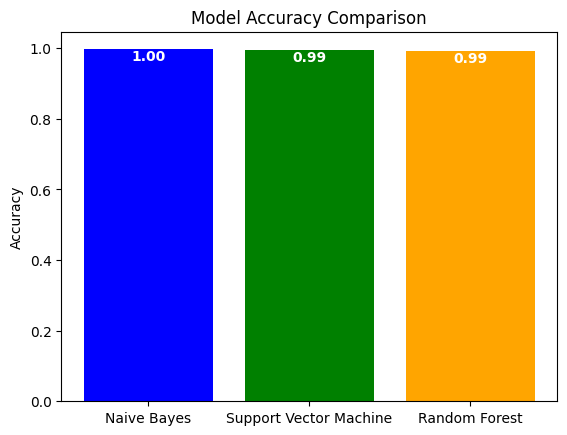

In [ ]:
import matplotlib.pyplot as plt

# Akurasi tiap model
accuracy_scores = {
    'Naive Bayes': accuracy_score(y_test, nb_pred),
    'Support Vector Machine': accuracy_score(y_test, svm_pred),
    'Random Forest': accuracy_score(y_test, rf_pred)
}

# Plot akurasi
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')

# Menampilkan nilai
for i, (model, accuracy) in enumerate(accuracy_scores.items()):
    plt.text(i, accuracy - 0.02, f'{accuracy:.2f}', ha='center', va='center', fontweight='bold', color='white')

plt.show()

In [ ]:
# Print akurasi setiap model
print("Hasil Akurasi Model:")
for model, acc in accuracy_scores.items():
    print(f"{model}: {acc:.4f}")  # Tampilkan hingga 4 desimal

Hasil Akurasi Model:
Naive Bayes: 0.9969
Support Vector Machine: 0.9937
Random Forest: 0.9906


# **Deployment**

In [ ]:
from joblib import load
import pickle

# Load model Naive Bayes
model_nb = load('nb_model.joblib')

# Load vocabulary dari TF-IDF
vocab = pickle.load(open('kbest_feature.pickle', 'rb'))

# Pastikan untuk memeriksa apakah model dan vocab sudah dimuat dengan benar
print("Model Naive Bayes berhasil dimuat:", model_nb)
print("Vocabulary berhasil dimuat:", vocab)

Model Naive Bayes berhasil dimuat: MultinomialNB()
Vocabulary berhasil dimuat: {'feel': 120, 'realli': 259, 'today': 347, 'like': 184, 'everyth': 108, 'fall': 114, 'apart': 15, 'great': 143, 'workout': 385, 'fantast': 117, 'full': 132, 'energi': 101, 'cannot': 40, 'seem': 280, 'shake': 288, 'empti': 98, 'linger': 186, 'day': 73, 'spent': 310, 'friend': 129, 'laugh': 175, 'enjoy': 102, 'other': 228, 'compani': 54, 'see': 278, 'point': 245, 'anyth': 14, 'anymor': 13, 'meaningless': 200, 'love': 196, 'even': 104, 'famili': 115, 'grate': 142, 'presenc': 248, 'alon': 8, 'world': 386, 'nobodi': 221, 'understand': 359, 'got': 141, 'promot': 255, 'work': 384, 'top': 349, 'unstopp': 361, 'noth': 223, 'ever': 105, 'get': 137, 'better': 29, 'trap': 352, 'endless': 100, 'cycl': 71, 'look': 192, 'forward': 128, 'weekend': 376, 'plan': 242, 'relax': 267, 'unwind': 362, 'sunshin': 330, 'lift': 182, 'spirit': 311, 'volunt': 367, 'fulfil': 131, 'bleak': 31, 'hopeless': 154, 'receiv': 260, 'heartfelt': 

In [ ]:
#@title Masukkan Teks Anda:
input_text = "I’m enjoying spending time with my family, it’s a great day."  # @param {type:"string"}

# Lakukan text preprocessing pada teks input
pre_input_text = text_preprocessing_process(input_text)

# Definisikan TF-IDF Vectorizer dengan kosakata yang sudah ada
tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))

# Prediksi menggunakan model Naive Bayes
prediction = nb_model.predict(tf_idf_vec.fit_transform([pre_input_text]))[0]

# Cetak hasil text preprocessing
print('Hasil Text Preprocessing:', pre_input_text)

# Mapping hasil prediksi ke label
if prediction == 0:
    result = 'Not Depressed'
elif prediction == 1:
    result = 'Depressed'
else:
    result = 'Unknown'  # Antisipasi jika hasil prediksi di luar cakupan

# Cetak hasil prediksi
print('Hasil prediksi', input_text, 'adalah', result)

Hasil Text Preprocessing: enjoy spend time famili great day
Hasil prediksi I’m enjoying spending time with my family, it’s a great day. adalah Not Depressed
